# Modelling of Abstractive Text Summarization

Data source:
<br> https://www.kaggle.com/snap/amazon-fine-food-reviews
<br> Code adpated from:
<br> https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
<br> https://towardsdatascience.com/how-to-evaluate-text-generation-models-metrics-for-automatic-evaluation-of-nlp-models-e1c251b04ec1
<br> https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460

## Import Modules

In [13]:
# Import modules and packages
import nltk
import string
import numpy as np  
import pandas as pd 
from nltk.corpus import stopwords  
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from utils import AttentionLayer  

## Load Cleaned Data

In [14]:
# Load master table
df = pd.read_csv("data.csv")
df = df.loc[:,['cleaned_text','cleaned_summary']]

# Set maximum length of inputs to model
max_text_len = 30
max_summary_len = 8

# Train test split, 90% training set and 10% test set
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(np.array(df['cleaned_text']),
                                                    np.array(df['cleaned_summary']),
                                                    test_size=0.1, random_state=0, shuffle=True) 

len(y_train), len(x_train), len(y_test), len(x_test)

(4771, 4771, 531, 531)

## Prepare Tokenizer

### Text Tokenizer

In [15]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer for reviews on training data
# filters='!"#&()*+,-/:;<=>?@[\\]^_`{|}~\t\n', lower=False, split=' ', char_level=False, oov_token=False
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [16]:
# Remove rare words with count below threshold
threshold = 4

count = 0
total_count = 0
freq = 0
tot_freq = 0

for key, value in x_tokenizer.word_counts.items():
    total_count = total_count + 1
    tot_freq = tot_freq + value
    if(value < threshold):
        count = count + 1
        freq = freq + value
    
print("% of rare words in vocabulary:", (count/total_count)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 68.6033791175398
Total Coverage of rare words: 9.234666728362214


In [17]:
# Prepare a tokenizer for reviews on training data, remove rare words
x_tokenizer = Tokenizer(num_words=total_count-count)
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences into integer sequences
x_train_seq = x_tokenizer.texts_to_sequences(x_train) 
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

# Padding zero up to maximum length
x_train = pad_sequences(x_train_seq, maxlen=max_text_len, padding='post') 
x_test = pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

# Size of vocab (+1 for padding token)
x_voc = x_tokenizer.num_words + 1
print(x_voc)

2584


In [18]:
count, total_count, freq, tot_freq

(5644, 8227, 7983, 86446)

### Summary Tokenizer 

In [19]:
# Prepare a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [20]:
# Remove rare words with count below threshold
threshold = 6

count = 0
total_count = 0
freq = 0
tot_freq = 0

for key, value in y_tokenizer.word_counts.items():
    total_count = total_count + 1
    tot_freq = tot_freq + value
    if(value < threshold):
        count = count + 1
        freq = freq + value
    
print("% of rare words in vocabulary:", (count/total_count)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 84.69192499043245
Total Coverage of rare words: 14.648837489459101


In [21]:
# Prepare a tokenizer for summary on training data 
y_tokenizer = Tokenizer(num_words=total_count-count)
y_tokenizer.fit_on_texts(list(y_train))

# Convert summary sequences into integer sequences
y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_test_seq = y_tokenizer.texts_to_sequences(y_test) 

# Padding zero up to maximum length
y_train = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

# Size of vocab (+1 for padding token)
y_voc = y_tokenizer.num_words +1
print(y_voc)

401


In [22]:
count, total_count, freq, tot_freq

(2213, 2613, 3648, 24903)

In [23]:
# Check word count of start token is equal to length of training data
y_tokenizer.word_counts['sumhajime'],len(y_train)   

(4771, 4771)

In [24]:
# Delete rows that contain only start and end tokens

ind = []
for i in range(len(y_train)):
    cnt=0
    for j in y_train[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_train = np.delete(y_train, ind, axis=0)
x_train = np.delete(x_train, ind, axis=0)

ind = []
for i in range(len(y_test)):
    cnt=0
    for j in y_test[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_test = np.delete(y_test, ind, axis=0)
x_test = np.delete(x_test, ind, axis=0)

In [25]:
len(y_train), len(x_train), len(y_test), len(x_test)

(4433, 4433, 485, 485)

## Modelling

Return Sequences = True: when True, LSTM produces the hidden state and cell state for every timestep

Return State = True: when True, LSTM produces the hidden state and cell state of the last timestep only

Initial State: used to initialize the internal states of the LSTM for the first timestep

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other, which leads to a better representation of the sequence. 

In the following, we build a 3 stacked LSTM for the encoder:

In [26]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder 
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, 
                     recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,
                     recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                     dropout=0.4, recurrent_dropout=0.4)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])   

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 100)      258400      ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 30, 300),    481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [27]:
# Specify loss function with sparse categorical cross-entropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# Specify early stopping with validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2, 
                   restore_best_weights=True)

# Specify batch size
history = model.fit([x_train, y_train[:,:-1]], 
                    y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
                    epochs=50, callbacks=[es], batch_size=128, 
                    validation_data = ([x_test, y_test[:,:-1]], 
                                       y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:]))

# Save best model
model.save('model.h5')

Epoch 1/50
35/35 [==============================] - 149s 4s/step - loss: 2.8402 - val_loss: 2.2659
Epoch 2/50
35/35 [==============================] - 137s 4s/step - loss: 2.2692 - val_loss: 2.0506
Epoch 3/50
35/35 [==============================] - 149s 4s/step - loss: 2.1407 - val_loss: 2.0864
Epoch 4/50
35/35 [==============================] - 147s 4s/step - loss: 2.1019 - val_loss: 1.9686
Epoch 5/50
35/35 [==============================] - 133s 4s/step - loss: 2.0584 - val_loss: 1.9390
Epoch 6/50
35/35 [==============================] - 142s 4s/step - loss: 2.0217 - val_loss: 1.9202
Epoch 7/50
35/35 [==============================] - 132s 4s/step - loss: 1.9869 - val_loss: 1.9187
Epoch 8/50
35/35 [==============================] - 135s 4s/step - loss: 1.9628 - val_loss: 1.8983
Epoch 9/50
35/35 [==============================] - 139s 4s/step - loss: 1.9401 - val_loss: 1.8954
Epoch 10/50
35/35 [==============================] - 140s 4s/step - loss: 1.9126 - val_loss: 1.9192
Epoch 11/

### Diagnostic plot

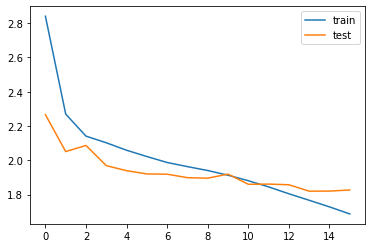

In [28]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.savefig('diagnostic_plot')
pyplot.show()

In [29]:
# Build dictionary to convert index to word for target and source vocabulary
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

### Inference

Set up the inference for the encoder and decoder:

In [30]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Tensors below will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [31]:
# Define function to implement inference process 
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sumhajime']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='sumowari'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'sumowari' or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [32]:
# Define functions to convert an integer sequence to a word sequence for summary and text
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sumhajime']) and i!=target_word_index['sumowari']):
            newString = newString + reverse_target_word_index[i] + ' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString = newString + reverse_source_word_index[i] + ' '
    return newString

In [33]:
# Print out summaries predicted for the training set
for i in range(0,20):
    print("Text:", seq2text(x_train[i]))
    print("Original Summary:", seq2summary(y_train[i]))
    print("Predicted summary:", decode_sequence(x_train[i].reshape(1, max_text_len)))
    print("\n")


Text: love product best natural sweetener ever tried tried many use also pancake syrup substitute honey peanut butter honey sandwich last long time good value 
Original Summary: the best 
Predicted summary:  great for


Text: searching alternative sausages years eaten many gross sausages best substitute found 
Original Summary: great 
Predicted summary:  great


Text: year old son diagnosed allergic soy peanuts sunflower butter found free allergens processed shared product buy son likes pb crackers sugars added much healthy 
Original Summary: only butter we will buy 
Predicted summary:  great


Text: favorite coffees tried smooth flavorful without flavored coffee definite treat anytime day 
Original Summary: great brew 
Predicted summary:  great coffee


Text: excellent tasting remember order later 
Original Summary: senseo coffee french vanilla caramel 
Predicted summary:  great product


Text: plant arrived dead cost much ship want kind return know better buy plant line 
Original Sum

In [34]:
# Print out summaries predicted for the test set
test_text_ref = []
test_sum_ref = []
test_sum_pred = []
for i in range(0, len(x_test)):
    test_text_ref.append(seq2text(x_test[i]))
    test_sum_ref.append(seq2summary(y_test[i]))
    test_sum_pred.append(decode_sequence(x_test[i].reshape(1, max_text_len)))

In [38]:
df_test = pd.DataFrame({'ori_text': test_text_ref, 'ori_sum': test_sum_ref, 'pred': test_sum_pred})
df_test.to_csv('df_test.csv') 

In [36]:
# Print out summaries predicted for the train set
train_text_ref = []
train_sum_ref = []
train_sum_pred = []
for i in range(0, len(x_train)):
    train_text_ref.append(seq2text(x_train[i]))
    train_sum_ref.append(seq2summary(y_train[i]))
    train_sum_pred.append(decode_sequence(x_train[i].reshape(1, max_text_len)))

In [39]:
df_train = pd.DataFrame({'ori_text': train_text_ref, 'ori_sum': train_sum_ref, 'pred': train_sum_pred})
df_train.to_csv('df_train.csv') 

# Performance Evaluation Metrics

The BLEU score (precision focused with brevity penalty) and ROUGE-n score (recall focused) with 2-grams overlap are used to evaluate the model's performance in generating a predicted summary that is true to the reference summary. The n-gram overlap means that the evaluation scheme is word-position independent apart from n-grams’ term associations.

In [70]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu

def bleu(ref, gen):
    ''' 
    calculate pair wise bleu score. uses nltk implementation
    Args:
        references : a list of reference sentences 
        candidates : a list of candidate(generated) sentences
    Returns:
        bleu score(float)
    '''
    ref_bleu = []
    gen_bleu = []
    for l in gen:
        gen_bleu.append(l.split())
    for i,l in enumerate(ref):
        ref_bleu.append([l.split()])
    cc = SmoothingFunction()
    score_bleu = corpus_bleu(ref_bleu, gen_bleu, weights=(0, 1, 0, 0), smoothing_function=cc.method4)
    return score_bleu

In [71]:
#rouge scores for a reference/generated sentence pair
#source google seq2seq source code.

import itertools

#supporting function
def _split_into_words(sentences):
    """Splits multiple sentences into words and flattens the result"""
    return list(itertools.chain(*[_.split(" ") for _ in sentences]))

#supporting function
def _get_word_ngrams(n, sentences):
    """Calculates word n-grams for multiple sentences.
    """
    assert len(sentences) > 0
    assert n > 0

    words = _split_into_words(sentences)
    return _get_ngrams(n, words)

#supporting function
def _get_ngrams(n, text):
    """Calcualtes n-grams.
    Args:
    n: which n-grams to calculate
    text: An array of tokens
    Returns:
    A set of n-grams
    """
    ngram_set = set()
    text_length = len(text)
    max_index_ngram_start = text_length - n
    for i in range(max_index_ngram_start + 1):
        ngram_set.add(tuple(text[i:i + n]))
    return ngram_set

def rouge_n(reference_sentences, evaluated_sentences, n=2):
    """
    Computes ROUGE-N of two text collections of sentences.
    Source: http://research.microsoft.com/en-us/um/people/cyl/download/
    papers/rouge-working-note-v1.3.1.pdf
    Args:
    evaluated_sentences: The sentences that have been picked by the summarizer
    reference_sentences: The sentences from the referene set
    n: Size of ngram.  Defaults to 2.
    Returns:
    recall rouge score(float)
    Raises:
    ValueError: raises exception if a param has len <= 0
    """
    if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
        raise ValueError("Collections must contain at least 1 sentence.")

    evaluated_ngrams = _get_word_ngrams(n, evaluated_sentences)
    reference_ngrams = _get_word_ngrams(n, reference_sentences)
    reference_count = len(reference_ngrams)
    evaluated_count = len(evaluated_ngrams)

    # Gets the overlapping ngrams between evaluated and reference
    overlapping_ngrams = evaluated_ngrams.intersection(reference_ngrams)
    overlapping_count = len(overlapping_ngrams)

    # Handle edge case. This isn't mathematically correct, but it's good enough
    if evaluated_count == 0:
        precision = 0.0
    else:
        precision = overlapping_count / evaluated_count

    if reference_count == 0:
        recall = 0.0
    else:
        recall = overlapping_count / reference_count

    f1_score = 2.0 * ((precision * recall) / (precision + recall + 1e-8))

    #just returning recall count in rouge, useful for our purpose
    return recall

In [72]:
'''
read from files - 
ref.txt : reference texts
gen.txt : generated texts (from model)
these files should be in the same directory
'''

def evaluation_metrics(ref_file_path, gen_file_path, n_for_rouge = 2):
    '''
    Args:
        ref_file_path (string) : reference file path -> file containing the reference sentences on each line
        gen_file_path (string) : model generated file path -> containing corresponding generated sentences(to reference sentences) on each line
    
    Returns:
        A list containing [bleu, rouge, meteor, ter]
    '''
    file_ref = open(ref_file_path, 'r')
    ref = file_ref.readlines()

    file_gen = open(gen_file_path, 'r')
    gen = file_gen.readlines()

    for i,l in enumerate(gen):
        gen[i] = l.strip()

    for i,l in enumerate(ref):
        ref[i] = l.strip()
    
    bleu_score = bleu(ref, gen)
    rouge_score = rouge_n(ref, gen, n=n_for_rouge)
    return [bleu_score, rouge_score]

In [73]:
# Write test lists to files
with open('test_sum_ref.txt', 'w') as filehandle:
    for listitem in test_sum_ref:
        filehandle.write('%s\n' % listitem)
        
with open('test_sum_pred.txt', 'w') as filehandle:
    for listitem in test_sum_pred:
        filehandle.write('%s\n' % listitem)

In [74]:
scores_test = evaluation_metrics('test_sum_ref.txt', 'test_sum_pred.txt', n_for_rouge = 2)
scores_test

[0.009867786804582964, 0.03303303303303303]

In [75]:
# Write train lists to files
with open('train_sum_ref.txt', 'w') as filehandle:
    for listitem in train_sum_ref:
        filehandle.write('%s\n' % listitem)
        
with open('train_sum_pred.txt', 'w') as filehandle:
    for listitem in train_sum_pred:
        filehandle.write('%s\n' % listitem)

In [77]:
scores_train = evaluation_metrics('train_sum_ref.txt', 'train_sum_pred.txt', n_for_rouge = 2)
scores_train

[0.015114726727201119, 0.019758002756930616]

In [78]:
from rouge import Rouge
rouge = Rouge()
rouge_scores_train = rouge.get_scores('train_sum_pred.txt', 'train_sum_ref.txt', avg=True)
rouge_scores_test = rouge.get_scores('test_sum_pred.txt', 'test_sum_ref.txt', avg=True)
print(rouge_scores_train)
print(rouge_scores_test)

{'rouge-1': {'r': 0.5, 'p': 0.5, 'f': 0.4999999950000001}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.5, 'p': 0.5, 'f': 0.4999999950000001}}
{'rouge-1': {'r': 0.5, 'p': 0.5, 'f': 0.4999999950000001}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.5, 'p': 0.5, 'f': 0.4999999950000001}}
